In [1]:
# Imports
import os
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
N_JOBS = 6
SEED = 2016

DATA = "Time"

In [2]:
# Get data
train = pd.read_csv("raw_data/input_train.csv", sep = ";")
test = pd.read_csv("raw_data/input_test.csv", sep = ";")
y = pd.read_csv("raw_data/output_train.csv", sep = ";")
print("train : " + str(train.shape))
print("test : " + str(test.shape))
print("y : " + str(y.shape))

alldata = pd.concat([train, test], axis = 0)
display(alldata.head())
display(y.head())

# Rename and change order of columns
alldata.columns = ["Id", "Id_bat", "Time", "SensorA", "WeatherA", "SensorB", "SensorC", "WeatherB"]
alldata = pd.concat([alldata.Id, alldata.Id_bat, alldata.Time, alldata.SensorA, alldata.SensorB, alldata.SensorC, 
                     alldata.WeatherA, alldata.WeatherB], axis = 1)
display(alldata.head())

# Differentiate numerical features (minus the target) and categorical features
cat_features = alldata.select_dtypes(include = ["object"]).columns
print("Categorical features : " + str(len(cat_features)))
num_features = alldata.select_dtypes(exclude = ["object"]).columns
print("Numerical features : " + str(len(num_features)))

train : (11708, 8)
test : (2429, 8)
y : (11708, 6)


,Id,Id_bat,Time,x1,x2,x3,x4,x5
0,0,1,2016-01-01 00:00:00,1.500,8.100,22.000,380.183,20.000
1,1,1,2016-01-01 01:00:00,1.600,8.200,21.900,378.100,120.000
2,2,1,2016-01-01 02:00:00,1.400,7.900,21.900,374.983,120.000
3,3,1,2016-01-01 03:00:00,1.600,6.900,21.800,376.017,120.000
4,4,1,2016-01-01 04:00:00,1.400,6.300,21.800,376.017,120.000


,Id,y1,y2,y3,y4,y5
0,0,110.500,40.900,0.000,48,13.940
1,1,110.800,38.600,0.000,48,20.910
2,2,112.600,37.000,0.000,48,20.910
3,3,110.900,37.600,0.000,48,41.820
4,4,112.500,38.400,0.000,52,69.700


,Id,Id_bat,Time,SensorA,SensorB,SensorC,WeatherA,WeatherB
0,0,1,2016-01-01 00:00:00,1.500,22.000,380.183,8.100,20.000
1,1,1,2016-01-01 01:00:00,1.600,21.900,378.100,8.200,120.000
2,2,1,2016-01-01 02:00:00,1.400,21.900,374.983,7.900,120.000
3,3,1,2016-01-01 03:00:00,1.600,21.800,376.017,6.900,120.000
4,4,1,2016-01-01 04:00:00,1.400,21.800,376.017,6.300,120.000


Categorical features : 1
Numerical features : 7


In [3]:
# Imputing NAs
train = alldata.iloc[:train.shape[0], :]
test = alldata.iloc[train.shape[0]: , :]

print("NAs : " + str(alldata.isnull().values.sum()))
print(alldata.isnull().sum())

# Imput NAs as median of that variable for this building
def replaceBySAMedians(group):
    group = group.fillna(train["SensorA"].groupby(train["Id_bat"]).median()[group.name])
    return group
def replaceBySBMedians(group):
    group = group.fillna(train["SensorB"].groupby(train["Id_bat"]).median()[group.name])
    return group
def replaceBySCMedians(group):
    group = group.fillna(train["SensorC"].groupby(train["Id_bat"]).median()[group.name])
    return group
def replaceByWAMedians(group):
    group = group.fillna(train["WeatherA"].groupby(train["Id_bat"]).median()[group.name])
    return group
def replaceByWBMedians(group):
    group = group.fillna(train["WeatherB"].groupby(train["Id_bat"]).median()[group.name])
    return group

alldata.loc[:, "SensorA"] = alldata.loc[:, "SensorA"].groupby(train["Id_bat"]).transform(replaceBySAMedians)
alldata.loc[:, "SensorB"] = alldata.loc[:, "SensorB"].groupby(train["Id_bat"]).transform(replaceBySBMedians)
alldata.loc[:, "SensorC"] = alldata.loc[:, "SensorC"].groupby(train["Id_bat"]).transform(replaceBySCMedians)
alldata.loc[:, "WeatherA"] = alldata.loc[:, "WeatherA"].groupby(train["Id_bat"]).transform(replaceByWAMedians)
alldata.loc[:, "WeatherB"] = alldata.loc[:, "WeatherB"].groupby(train["Id_bat"]).transform(replaceByWBMedians)

print("After NA imputing, remaining NAs : " + str(alldata.isnull().values.sum()))

NAs : 745
Id            0
Id_bat        0
Time          0
SensorA      47
SensorB      47
SensorC     321
WeatherA    149
WeatherB    181
dtype: int64
After NA imputing, remaining NAs : 0


In [4]:
# Transform Time field
alldata["Date"], alldata["Hour"] = alldata["Time"].str.split(" ", 1).str
alldata["Year"], alldata["Month"], alldata["DayOfMonth"] = alldata["Date"].str.split("-").str
alldata["Hour"], alldata["Minutes"], alldata["Seconds"] = alldata["Hour"].str.split(":").str
alldata["Hour"] = alldata["Hour"].astype(int)
alldata["DayOfMonth"] = alldata["DayOfMonth"].astype(int)
alldata["Month"] = alldata["Month"].astype(int)

alldata = alldata.drop(["Time", "Date", "Year", "Minutes", "Seconds"], axis = 1)


In [5]:
# Create Week, DayOfWeek and DayOfYear features
alldata.loc[alldata.Month == 1, "DayOfYear"] = alldata.loc[alldata.Month == 1, "DayOfMonth"]
alldata.loc[alldata.Month == 2, "DayOfYear"] = alldata.loc[alldata.Month == 2, "DayOfMonth"] + 31
alldata.loc[alldata.Month == 3, "DayOfYear"] = alldata.loc[alldata.Month == 3, "DayOfMonth"] + 60
alldata.loc[alldata.Month == 4, "DayOfYear"] = alldata.loc[alldata.Month == 4, "DayOfMonth"] + 91
alldata.loc[alldata.Month == 5, "DayOfYear"] = alldata.loc[alldata.Month == 5, "DayOfMonth"] + 121
alldata.loc[alldata.Month == 6, "DayOfYear"] = alldata.loc[alldata.Month == 6, "DayOfMonth"] + 152
alldata["DayOfYear"] = alldata["DayOfYear"].apply(int)

alldata["DayOfWeek"] = (alldata["DayOfYear"]) % 7
alldata["DayOfWeek"] = alldata["DayOfWeek"].apply(int)

alldata["Week"] = (alldata["DayOfYear"] / 7) + 1
alldata["Week"] = alldata["Week"].apply(int)

In [6]:
# Start training on 2nd day (for lags features)
train = alldata.iloc[:train.shape[0], :]
test = alldata.iloc[train.shape[0]: , :]

y = y.loc[train.Id > 23]
train = train.loc[train.Id > 23]

In [7]:
# Remove Id field
train = train.drop(["Id"], axis = 1)

In [8]:
# Split data by date for validation and ensembling
X_train = train.loc[train.Month < 4]
y_train = y.loc[train.Month < 4]
X_test = train.loc[train.Month == 4]
y_test = y.loc[train.Month == 4]

X_trainVal = X_train.loc[X_train.Month < 3]
y_trainVal = y_train.loc[X_train.Month < 3]
X_testVal = X_train.loc[X_train.Month == 3]
y_testVal = y_train.loc[X_train.Month == 3]

In [9]:
print(X_train.shape)
print(X_trainVal.shape)
print(X_testVal.shape)


(8708, 12)
(5736, 12)
(2972, 12)


In [10]:
# Look at special cases
print("Important remark: for some buildings, some consumptions are not used to heat/cool rooms. In this case, all data of \
the corresponding output are set to 0 (zero) and this output has to be ignored (you do not have to predict it). This \
is for instance the case for output y3 for building with Id_bat 1.")
temp_train = pd.concat([train, y], axis = 1)
print(temp_train.groupby(["Id_bat"]).y1.sum())
print("-----")
print(temp_train.groupby(["Id_bat"]).y2.sum())
print("-----")
print(temp_train.groupby(["Id_bat"]).y3.sum())
print("-----")
print(temp_train.groupby(["Id_bat"]).y4.sum())
print("-----")
print(temp_train.groupby(["Id_bat"]).y5.sum())
print("-----")


Important remark: for some buildings, some consumptions are not used to heat/cool rooms. In this case, all data of the corresponding output are set to 0 (zero) and this output has to be ignored (you do not have to predict it). This is for instance the case for output y3 for building with Id_bat 1.
Id_bat
1   462049.150
2   335948.500
3   793784.000
4   428253.000
Name: y1, dtype: float64
-----
Id_bat
1    141841.700
2    533953.900
3         0.000
4   1154863.360
Name: y2, dtype: float64
-----
Id_bat
1       0.000
2       0.000
3   34159.900
4       0.000
Name: y3, dtype: float64
-----
Id_bat
1    282264
2     84922
3         0
4    491256
Name: y4, dtype: int64
-----
Id_bat
1   481564.270
2   380700.000
3   755410.000
4   135190.000
Name: y5, dtype: float64
-----


In [11]:
# Prepare one training set for each target variable and building, removing the correct rows
train_y1b1 = train[train.Id_bat == 1]
train_y1b2 = train[train.Id_bat == 2]
train_y1b3 = train[train.Id_bat == 3]
train_y1b4 = train[train.Id_bat == 4]

train_y2b1 = train[train.Id_bat == 1]
train_y2b2 = train[train.Id_bat == 2]
train_y2b4 = train[train.Id_bat == 4]

train_y3b3 = train[train.Id_bat == 3]

train_y4b1 = train[train.Id_bat == 1]
train_y4b2 = train[train.Id_bat == 2]
train_y4b4 = train[train.Id_bat == 4]

train_y5b1 = train[train.Id_bat == 1]
train_y5b2 = train[train.Id_bat == 2]
train_y5b3 = train[train.Id_bat == 3]
train_y5b4 = train[train.Id_bat == 4]
#####
X_train_y1b1 = X_train[X_train.Id_bat == 1]
X_train_y1b2 = X_train[X_train.Id_bat == 2]
X_train_y1b3 = X_train[X_train.Id_bat == 3]
X_train_y1b4 = X_train[X_train.Id_bat == 4]

X_train_y2b1 = X_train[X_train.Id_bat == 1]
X_train_y2b2 = X_train[X_train.Id_bat == 2]
X_train_y2b4 = X_train[X_train.Id_bat == 4]

X_train_y3b3 = X_train[X_train.Id_bat == 3]

X_train_y4b1 = X_train[X_train.Id_bat == 1]
X_train_y4b2 = X_train[X_train.Id_bat == 2]
X_train_y4b4 = X_train[X_train.Id_bat == 4]

X_train_y5b1 = X_train[X_train.Id_bat == 1]
X_train_y5b2 = X_train[X_train.Id_bat == 2]
X_train_y5b3 = X_train[X_train.Id_bat == 3]
X_train_y5b4 = X_train[X_train.Id_bat == 4]
#####
X_trainVal_y1b1 = X_trainVal[X_trainVal.Id_bat == 1]
X_trainVal_y1b2 = X_trainVal[X_trainVal.Id_bat == 2]
X_trainVal_y1b3 = X_trainVal[X_trainVal.Id_bat == 3]
X_trainVal_y1b4 = X_trainVal[X_trainVal.Id_bat == 4]

X_trainVal_y2b1 = X_trainVal[X_trainVal.Id_bat == 1]
X_trainVal_y2b2 = X_trainVal[X_trainVal.Id_bat == 2]
X_trainVal_y2b4 = X_trainVal[X_trainVal.Id_bat == 4]

X_trainVal_y3b3 = X_trainVal[X_trainVal.Id_bat == 3]

X_trainVal_y4b1 = X_trainVal[X_trainVal.Id_bat == 1]
X_trainVal_y4b2 = X_trainVal[X_trainVal.Id_bat == 2]
X_trainVal_y4b4 = X_trainVal[X_trainVal.Id_bat == 4]

X_trainVal_y5b1 = X_trainVal[X_trainVal.Id_bat == 1]
X_trainVal_y5b2 = X_trainVal[X_trainVal.Id_bat == 2]
X_trainVal_y5b3 = X_trainVal[X_trainVal.Id_bat == 3]
X_trainVal_y5b4 = X_trainVal[X_trainVal.Id_bat == 4]
#####
test_y1b1 = test[test.Id_bat == 1]
test_y1b2 = test[test.Id_bat == 2]
test_y1b3 = test[test.Id_bat == 3]
test_y1b4 = test[test.Id_bat == 4]

test_y2b1 = test[test.Id_bat == 1]
test_y2b2 = test[test.Id_bat == 2]
test_y2b4 = test[test.Id_bat == 4]

test_y3b3 = test[test.Id_bat == 3]

test_y4b1 = test[test.Id_bat == 1]
test_y4b2 = test[test.Id_bat == 2]
test_y4b4 = test[test.Id_bat == 4]

test_y5b1 = test[test.Id_bat == 1]
test_y5b2 = test[test.Id_bat == 2]
test_y5b3 = test[test.Id_bat == 3]
test_y5b4 = test[test.Id_bat == 4]
#####
X_test_y1b1 = X_test[X_test.Id_bat == 1]
X_test_y1b2 = X_test[X_test.Id_bat == 2]
X_test_y1b3 = X_test[X_test.Id_bat == 3]
X_test_y1b4 = X_test[X_test.Id_bat == 4]

X_test_y2b1 = X_test[X_test.Id_bat == 1]
X_test_y2b2 = X_test[X_test.Id_bat == 2]
X_test_y2b4 = X_test[X_test.Id_bat == 4]

X_test_y3b3 = X_test[X_test.Id_bat == 3]

X_test_y4b1 = X_test[X_test.Id_bat == 1]
X_test_y4b2 = X_test[X_test.Id_bat == 2]
X_test_y4b4 = X_test[X_test.Id_bat == 4]

X_test_y5b1 = X_test[X_test.Id_bat == 1]
X_test_y5b2 = X_test[X_test.Id_bat == 2]
X_test_y5b3 = X_test[X_test.Id_bat == 3]
X_test_y5b4 = X_test[X_test.Id_bat == 4]
#####
X_testVal_y1b1 = X_testVal[X_testVal.Id_bat == 1]
X_testVal_y1b2 = X_testVal[X_testVal.Id_bat == 2]
X_testVal_y1b3 = X_testVal[X_testVal.Id_bat == 3]
X_testVal_y1b4 = X_testVal[X_testVal.Id_bat == 4]

X_testVal_y2b1 = X_testVal[X_testVal.Id_bat == 1]
X_testVal_y2b2 = X_testVal[X_testVal.Id_bat == 2]
X_testVal_y2b4 = X_testVal[X_testVal.Id_bat == 4]

X_testVal_y3b3 = X_testVal[X_testVal.Id_bat == 3]

X_testVal_y4b1 = X_testVal[X_testVal.Id_bat == 1]
X_testVal_y4b2 = X_testVal[X_testVal.Id_bat == 2]
X_testVal_y4b4 = X_testVal[X_testVal.Id_bat == 4]

X_testVal_y5b1 = X_testVal[X_testVal.Id_bat == 1]
X_testVal_y5b2 = X_testVal[X_testVal.Id_bat == 2]
X_testVal_y5b3 = X_testVal[X_testVal.Id_bat == 3]
X_testVal_y5b4 = X_testVal[X_testVal.Id_bat == 4]
#####
y_y1b1 = y[train.Id_bat == 1][["Id", "y1"]]
y_y1b2 = y[train.Id_bat == 2][["Id", "y1"]]
y_y1b3 = y[train.Id_bat == 3][["Id", "y1"]]
y_y1b4 = y[train.Id_bat == 4][["Id", "y1"]]

y_y2b1 = y[train.Id_bat == 1][["Id", "y2"]]
y_y2b2 = y[train.Id_bat == 2][["Id", "y2"]]
y_y2b4 = y[train.Id_bat == 4][["Id", "y2"]]

y_y3b3 = y[train.Id_bat == 3][["Id", "y3"]]

y_y4b1 = y[train.Id_bat == 1][["Id", "y4"]]
y_y4b2 = y[train.Id_bat == 2][["Id", "y4"]]
y_y4b4 = y[train.Id_bat == 4][["Id", "y4"]]

y_y5b1 = y[train.Id_bat == 1][["Id", "y5"]]
y_y5b2 = y[train.Id_bat == 2][["Id", "y5"]]
y_y5b3 = y[train.Id_bat == 3][["Id", "y5"]]
y_y5b4 = y[train.Id_bat == 4][["Id", "y5"]]
#####
y_train_y1b1 = y_train[X_train.Id_bat == 1][["Id", "y1"]]
y_train_y1b2 = y_train[X_train.Id_bat == 2][["Id", "y1"]]
y_train_y1b3 = y_train[X_train.Id_bat == 3][["Id", "y1"]]
y_train_y1b4 = y_train[X_train.Id_bat == 4][["Id", "y1"]]

y_train_y2b1 = y_train[X_train.Id_bat == 1][["Id", "y2"]]
y_train_y2b2 = y_train[X_train.Id_bat == 2][["Id", "y2"]]
y_train_y2b4 = y_train[X_train.Id_bat == 4][["Id", "y2"]]

y_train_y3b3 = y_train[X_train.Id_bat == 3][["Id", "y3"]]

y_train_y4b1 = y_train[X_train.Id_bat == 1][["Id", "y4"]]
y_train_y4b2 = y_train[X_train.Id_bat == 2][["Id", "y4"]]
y_train_y4b4 = y_train[X_train.Id_bat == 4][["Id", "y4"]]

y_train_y5b1 = y_train[X_train.Id_bat == 1][["Id", "y5"]]
y_train_y5b2 = y_train[X_train.Id_bat == 2][["Id", "y5"]]
y_train_y5b3 = y_train[X_train.Id_bat == 3][["Id", "y5"]]
y_train_y5b4 = y_train[X_train.Id_bat == 4][["Id", "y5"]]
#####
y_trainVal_y1b1 = y_trainVal[X_trainVal.Id_bat == 1][["Id", "y1"]]
y_trainVal_y1b2 = y_trainVal[X_trainVal.Id_bat == 2][["Id", "y1"]]
y_trainVal_y1b3 = y_trainVal[X_trainVal.Id_bat == 3][["Id", "y1"]]
y_trainVal_y1b4 = y_trainVal[X_trainVal.Id_bat == 4][["Id", "y1"]]

y_trainVal_y2b1 = y_trainVal[X_trainVal.Id_bat == 1][["Id", "y2"]]
y_trainVal_y2b2 = y_trainVal[X_trainVal.Id_bat == 2][["Id", "y2"]]
y_trainVal_y2b4 = y_trainVal[X_trainVal.Id_bat == 4][["Id", "y2"]]

y_trainVal_y3b3 = y_trainVal[X_trainVal.Id_bat == 3][["Id", "y3"]]

y_trainVal_y4b1 = y_trainVal[X_trainVal.Id_bat == 1][["Id", "y4"]]
y_trainVal_y4b2 = y_trainVal[X_trainVal.Id_bat == 2][["Id", "y4"]]
y_trainVal_y4b4 = y_trainVal[X_trainVal.Id_bat == 4][["Id", "y4"]]

y_trainVal_y5b1 = y_trainVal[X_trainVal.Id_bat == 1][["Id", "y5"]]
y_trainVal_y5b2 = y_trainVal[X_trainVal.Id_bat == 2][["Id", "y5"]]
y_trainVal_y5b3 = y_trainVal[X_trainVal.Id_bat == 3][["Id", "y5"]]
y_trainVal_y5b4 = y_trainVal[X_trainVal.Id_bat == 4][["Id", "y5"]]
#####
y_test_y1b1 = y_test[X_test.Id_bat == 1][["Id", "y1"]]
y_test_y1b2 = y_test[X_test.Id_bat == 2][["Id", "y1"]]
y_test_y1b3 = y_test[X_test.Id_bat == 3][["Id", "y1"]]
y_test_y1b4 = y_test[X_test.Id_bat == 4][["Id", "y1"]]

y_test_y2b1 = y_test[X_test.Id_bat == 1][["Id", "y2"]]
y_test_y2b2 = y_test[X_test.Id_bat == 2][["Id", "y2"]]
y_test_y2b4 = y_test[X_test.Id_bat == 4][["Id", "y2"]]

y_test_y3b3 = y_test[X_test.Id_bat == 3][["Id", "y3"]]

y_test_y4b1 = y_test[X_test.Id_bat == 1][["Id", "y4"]]
y_test_y4b2 = y_test[X_test.Id_bat == 2][["Id", "y4"]]
y_test_y4b4 = y_test[X_test.Id_bat == 4][["Id", "y4"]]

y_test_y5b1 = y_test[X_test.Id_bat == 1][["Id", "y5"]]
y_test_y5b2 = y_test[X_test.Id_bat == 2][["Id", "y5"]]
y_test_y5b3 = y_test[X_test.Id_bat == 3][["Id", "y5"]]
y_test_y5b4 = y_test[X_test.Id_bat == 4][["Id", "y5"]]
#####
y_testVal_y1b1 = y_testVal[X_testVal.Id_bat == 1][["Id", "y1"]]
y_testVal_y1b2 = y_testVal[X_testVal.Id_bat == 2][["Id", "y1"]]
y_testVal_y1b3 = y_testVal[X_testVal.Id_bat == 3][["Id", "y1"]]
y_testVal_y1b4 = y_testVal[X_testVal.Id_bat == 4][["Id", "y1"]]

y_testVal_y2b1 = y_testVal[X_testVal.Id_bat == 1][["Id", "y2"]]
y_testVal_y2b2 = y_testVal[X_testVal.Id_bat == 2][["Id", "y2"]]
y_testVal_y2b4 = y_testVal[X_testVal.Id_bat == 4][["Id", "y2"]]

y_testVal_y3b3 = y_testVal[X_testVal.Id_bat == 3][["Id", "y3"]]

y_testVal_y4b1 = y_testVal[X_testVal.Id_bat == 1][["Id", "y4"]]
y_testVal_y4b2 = y_testVal[X_testVal.Id_bat == 2][["Id", "y4"]]
y_testVal_y4b4 = y_testVal[X_testVal.Id_bat == 4][["Id", "y4"]]

y_testVal_y5b1 = y_testVal[X_testVal.Id_bat == 1][["Id", "y5"]]
y_testVal_y5b2 = y_testVal[X_testVal.Id_bat == 2][["Id", "y5"]]
y_testVal_y5b3 = y_testVal[X_testVal.Id_bat == 3][["Id", "y5"]]
y_testVal_y5b4 = y_testVal[X_testVal.Id_bat == 4][["Id", "y5"]]


#####
y_test_y1 = y_test[["Id", "y1"]]
y_test_y2 = y_test[["Id", "y2"]]
y_test_y3 = y_test[["Id", "y3"]]
y_test_y4 = y_test[["Id", "y4"]]
y_test_y5 = y_test[["Id", "y5"]]


In [12]:
# Write data in CSV files
train_y1b1.to_csv("clean_data/train_y1b1_" + DATA + ".csv", index = False)
train_y1b2.to_csv("clean_data/train_y1b2_" + DATA + ".csv", index = False)
train_y1b3.to_csv("clean_data/train_y1b3_" + DATA + ".csv", index = False)
train_y1b4.to_csv("clean_data/train_y1b4_" + DATA + ".csv", index = False)

train_y2b1.to_csv("clean_data/train_y2b1_" + DATA + ".csv", index = False)
train_y2b2.to_csv("clean_data/train_y2b2_" + DATA + ".csv", index = False)
train_y2b4.to_csv("clean_data/train_y2b4_" + DATA + ".csv", index = False)

train_y3b3.to_csv("clean_data/train_y3b3_" + DATA + ".csv", index = False)

train_y4b1.to_csv("clean_data/train_y4b1_" + DATA + ".csv", index = False)
train_y4b2.to_csv("clean_data/train_y4b2_" + DATA + ".csv", index = False)
train_y4b4.to_csv("clean_data/train_y4b4_" + DATA + ".csv", index = False)

train_y5b1.to_csv("clean_data/train_y5b1_" + DATA + ".csv", index = False)
train_y5b2.to_csv("clean_data/train_y5b2_" + DATA + ".csv", index = False)
train_y5b3.to_csv("clean_data/train_y5b3_" + DATA + ".csv", index = False)
train_y5b4.to_csv("clean_data/train_y5b4_" + DATA + ".csv", index = False)
#####
X_train_y1b1.to_csv("clean_data/X_train_y1b1_" + DATA + ".csv", index = False)
X_train_y1b2.to_csv("clean_data/X_train_y1b2_" + DATA + ".csv", index = False)
X_train_y1b3.to_csv("clean_data/X_train_y1b3_" + DATA + ".csv", index = False)
X_train_y1b4.to_csv("clean_data/X_train_y1b4_" + DATA + ".csv", index = False)

X_train_y2b1.to_csv("clean_data/X_train_y2b1_" + DATA + ".csv", index = False)
X_train_y2b2.to_csv("clean_data/X_train_y2b2_" + DATA + ".csv", index = False)
X_train_y2b4.to_csv("clean_data/X_train_y2b4_" + DATA + ".csv", index = False)

X_train_y3b3.to_csv("clean_data/X_train_y3b3_" + DATA + ".csv", index = False)

X_train_y4b1.to_csv("clean_data/X_train_y4b1_" + DATA + ".csv", index = False)
X_train_y4b2.to_csv("clean_data/X_train_y4b2_" + DATA + ".csv", index = False)
X_train_y4b4.to_csv("clean_data/X_train_y4b4_" + DATA + ".csv", index = False)

X_train_y5b1.to_csv("clean_data/X_train_y5b1_" + DATA + ".csv", index = False)
X_train_y5b2.to_csv("clean_data/X_train_y5b2_" + DATA + ".csv", index = False)
X_train_y5b3.to_csv("clean_data/X_train_y5b3_" + DATA + ".csv", index = False)
X_train_y5b4.to_csv("clean_data/X_train_y5b4_" + DATA + ".csv", index = False)
#####
X_trainVal_y1b1.to_csv("clean_data/X_trainVal_y1b1_" + DATA + ".csv", index = False)
X_trainVal_y1b2.to_csv("clean_data/X_trainVal_y1b2_" + DATA + ".csv", index = False)
X_trainVal_y1b3.to_csv("clean_data/X_trainVal_y1b3_" + DATA + ".csv", index = False)
X_trainVal_y1b4.to_csv("clean_data/X_trainVal_y1b4_" + DATA + ".csv", index = False)

X_trainVal_y2b1.to_csv("clean_data/X_trainVal_y2b1_" + DATA + ".csv", index = False)
X_trainVal_y2b2.to_csv("clean_data/X_trainVal_y2b2_" + DATA + ".csv", index = False)
X_trainVal_y2b4.to_csv("clean_data/X_trainVal_y2b4_" + DATA + ".csv", index = False)

X_trainVal_y3b3.to_csv("clean_data/X_trainVal_y3b3_" + DATA + ".csv", index = False)

X_trainVal_y4b1.to_csv("clean_data/X_trainVal_y4b1_" + DATA + ".csv", index = False)
X_trainVal_y4b2.to_csv("clean_data/X_trainVal_y4b2_" + DATA + ".csv", index = False)
X_trainVal_y4b4.to_csv("clean_data/X_trainVal_y4b4_" + DATA + ".csv", index = False)

X_trainVal_y5b1.to_csv("clean_data/X_trainVal_y5b1_" + DATA + ".csv", index = False)
X_trainVal_y5b2.to_csv("clean_data/X_trainVal_y5b2_" + DATA + ".csv", index = False)
X_trainVal_y5b3.to_csv("clean_data/X_trainVal_y5b3_" + DATA + ".csv", index = False)
X_trainVal_y5b4.to_csv("clean_data/X_trainVal_y5b4_" + DATA + ".csv", index = False)
#####
'''test.to_csv("clean_data/test_" + DATA + ".csv", index = False)'''
test_y1b1.to_csv("clean_data/test_y1b1_" + DATA + ".csv", index = False)
test_y1b2.to_csv("clean_data/test_y1b2_" + DATA + ".csv", index = False)
test_y1b3.to_csv("clean_data/test_y1b3_" + DATA + ".csv", index = False)
test_y1b4.to_csv("clean_data/test_y1b4_" + DATA + ".csv", index = False)

test_y2b1.to_csv("clean_data/test_y2b1_" + DATA + ".csv", index = False)
test_y2b2.to_csv("clean_data/test_y2b2_" + DATA + ".csv", index = False)
test_y2b4.to_csv("clean_data/test_y2b4_" + DATA + ".csv", index = False)

test_y3b3.to_csv("clean_data/test_y3b3_" + DATA + ".csv", index = False)

test_y4b1.to_csv("clean_data/test_y4b1_" + DATA + ".csv", index = False)
test_y4b2.to_csv("clean_data/test_y4b2_" + DATA + ".csv", index = False)
test_y4b4.to_csv("clean_data/test_y4b4_" + DATA + ".csv", index = False)

test_y5b1.to_csv("clean_data/test_y5b1_" + DATA + ".csv", index = False)
test_y5b2.to_csv("clean_data/test_y5b2_" + DATA + ".csv", index = False)
test_y5b3.to_csv("clean_data/test_y5b3_" + DATA + ".csv", index = False)
test_y5b4.to_csv("clean_data/test_y5b4_" + DATA + ".csv", index = False)
#####
X_test_y1b1.to_csv("clean_data/X_test_y1b1_" + DATA + ".csv", index = False)
X_test_y1b2.to_csv("clean_data/X_test_y1b2_" + DATA + ".csv", index = False)
X_test_y1b3.to_csv("clean_data/X_test_y1b3_" + DATA + ".csv", index = False)
X_test_y1b4.to_csv("clean_data/X_test_y1b4_" + DATA + ".csv", index = False)

X_test_y2b1.to_csv("clean_data/X_test_y2b1_" + DATA + ".csv", index = False)
X_test_y2b2.to_csv("clean_data/X_test_y2b2_" + DATA + ".csv", index = False)
X_test_y2b4.to_csv("clean_data/X_test_y2b4_" + DATA + ".csv", index = False)

X_test_y3b3.to_csv("clean_data/X_test_y3b3_" + DATA + ".csv", index = False)

X_test_y4b1.to_csv("clean_data/X_test_y4b1_" + DATA + ".csv", index = False)
X_test_y4b2.to_csv("clean_data/X_test_y4b2_" + DATA + ".csv", index = False)
X_test_y4b4.to_csv("clean_data/X_test_y4b4_" + DATA + ".csv", index = False)

X_test_y5b1.to_csv("clean_data/X_test_y5b1_" + DATA + ".csv", index = False)
X_test_y5b2.to_csv("clean_data/X_test_y5b2_" + DATA + ".csv", index = False)
X_test_y5b3.to_csv("clean_data/X_test_y5b3_" + DATA + ".csv", index = False)
X_test_y5b4.to_csv("clean_data/X_test_y5b4_" + DATA + ".csv", index = False)
#####
X_testVal_y1b1.to_csv("clean_data/X_testVal_y1b1_" + DATA + ".csv", index = False)
X_testVal_y1b2.to_csv("clean_data/X_testVal_y1b2_" + DATA + ".csv", index = False)
X_testVal_y1b3.to_csv("clean_data/X_testVal_y1b3_" + DATA + ".csv", index = False)
X_testVal_y1b4.to_csv("clean_data/X_testVal_y1b4_" + DATA + ".csv", index = False)

X_testVal_y2b1.to_csv("clean_data/X_testVal_y2b1_" + DATA + ".csv", index = False)
X_testVal_y2b2.to_csv("clean_data/X_testVal_y2b2_" + DATA + ".csv", index = False)
X_testVal_y2b4.to_csv("clean_data/X_testVal_y2b4_" + DATA + ".csv", index = False)

X_testVal_y3b3.to_csv("clean_data/X_testVal_y3b3_" + DATA + ".csv", index = False)

X_testVal_y4b1.to_csv("clean_data/X_testVal_y4b1_" + DATA + ".csv", index = False)
X_testVal_y4b2.to_csv("clean_data/X_testVal_y4b2_" + DATA + ".csv", index = False)
X_testVal_y4b4.to_csv("clean_data/X_testVal_y4b4_" + DATA + ".csv", index = False)

X_testVal_y5b1.to_csv("clean_data/X_testVal_y5b1_" + DATA + ".csv", index = False)
X_testVal_y5b2.to_csv("clean_data/X_testVal_y5b2_" + DATA + ".csv", index = False)
X_testVal_y5b3.to_csv("clean_data/X_testVal_y5b3_" + DATA + ".csv", index = False)
X_testVal_y5b4.to_csv("clean_data/X_testVal_y5b4_" + DATA + ".csv", index = False)
#####
y_y1b1.to_csv("clean_data/y_y1b1.csv", index = False)
y_y1b2.to_csv("clean_data/y_y1b2.csv", index = False)
y_y1b3.to_csv("clean_data/y_y1b3.csv", index = False)
y_y1b4.to_csv("clean_data/y_y1b4.csv", index = False)

y_y2b1.to_csv("clean_data/y_y2b1.csv", index = False)
y_y2b2.to_csv("clean_data/y_y2b2.csv", index = False)
y_y2b4.to_csv("clean_data/y_y2b4.csv", index = False)

y_y3b3.to_csv("clean_data/y_y3b3.csv", index = False)

y_y4b1.to_csv("clean_data/y_y4b1.csv", index = False)
y_y4b2.to_csv("clean_data/y_y4b2.csv", index = False)
y_y4b4.to_csv("clean_data/y_y4b4.csv", index = False)

y_y5b1.to_csv("clean_data/y_y5b1.csv", index = False)
y_y5b2.to_csv("clean_data/y_y5b2.csv", index = False)
y_y5b3.to_csv("clean_data/y_y5b3.csv", index = False)
y_y5b4.to_csv("clean_data/y_y5b4.csv", index = False)
#####
y_train_y1b1.to_csv("clean_data/y_train_y1b1.csv", index = False)
y_train_y1b2.to_csv("clean_data/y_train_y1b2.csv", index = False)
y_train_y1b3.to_csv("clean_data/y_train_y1b3.csv", index = False)
y_train_y1b4.to_csv("clean_data/y_train_y1b4.csv", index = False)

y_train_y2b1.to_csv("clean_data/y_train_y2b1.csv", index = False)
y_train_y2b2.to_csv("clean_data/y_train_y2b2.csv", index = False)
y_train_y2b4.to_csv("clean_data/y_train_y2b4.csv", index = False)

y_train_y3b3.to_csv("clean_data/y_train_y3b3.csv", index = False)

y_train_y4b1.to_csv("clean_data/y_train_y4b1.csv", index = False)
y_train_y4b2.to_csv("clean_data/y_train_y4b2.csv", index = False)
y_train_y4b4.to_csv("clean_data/y_train_y4b4.csv", index = False)

y_train_y5b1.to_csv("clean_data/y_train_y5b1.csv", index = False)
y_train_y5b2.to_csv("clean_data/y_train_y5b2.csv", index = False)
y_train_y5b3.to_csv("clean_data/y_train_y5b3.csv", index = False)
y_train_y5b4.to_csv("clean_data/y_train_y5b4.csv", index = False)
#####
y_trainVal_y1b1.to_csv("clean_data/y_trainVal_y1b1.csv", index = False)
y_trainVal_y1b2.to_csv("clean_data/y_trainVal_y1b2.csv", index = False)
y_trainVal_y1b3.to_csv("clean_data/y_trainVal_y1b3.csv", index = False)
y_trainVal_y1b4.to_csv("clean_data/y_trainVal_y1b4.csv", index = False)

y_trainVal_y2b1.to_csv("clean_data/y_trainVal_y2b1.csv", index = False)
y_trainVal_y2b2.to_csv("clean_data/y_trainVal_y2b2.csv", index = False)
y_trainVal_y2b4.to_csv("clean_data/y_trainVal_y2b4.csv", index = False)

y_trainVal_y3b3.to_csv("clean_data/y_trainVal_y3b3.csv", index = False)

y_trainVal_y4b1.to_csv("clean_data/y_trainVal_y4b1.csv", index = False)
y_trainVal_y4b2.to_csv("clean_data/y_trainVal_y4b2.csv", index = False)
y_trainVal_y4b4.to_csv("clean_data/y_trainVal_y4b4.csv", index = False)

y_trainVal_y5b1.to_csv("clean_data/y_trainVal_y5b1.csv", index = False)
y_trainVal_y5b2.to_csv("clean_data/y_trainVal_y5b2.csv", index = False)
y_trainVal_y5b3.to_csv("clean_data/y_trainVal_y5b3.csv", index = False)
y_trainVal_y5b4.to_csv("clean_data/y_trainVal_y5b4.csv", index = False)
#####
y_test_y1b1.to_csv("clean_data/y_test_y1b1.csv", index = False)
y_test_y1b2.to_csv("clean_data/y_test_y1b2.csv", index = False)
y_test_y1b3.to_csv("clean_data/y_test_y1b3.csv", index = False)
y_test_y1b4.to_csv("clean_data/y_test_y1b4.csv", index = False)

y_test_y2b1.to_csv("clean_data/y_test_y2b1.csv", index = False)
y_test_y2b2.to_csv("clean_data/y_test_y2b2.csv", index = False)
y_test_y2b4.to_csv("clean_data/y_test_y2b4.csv", index = False)

y_test_y3b3.to_csv("clean_data/y_test_y3b3.csv", index = False)

y_test_y4b1.to_csv("clean_data/y_test_y4b1.csv", index = False)
y_test_y4b2.to_csv("clean_data/y_test_y4b2.csv", index = False)
y_test_y4b4.to_csv("clean_data/y_test_y4b4.csv", index = False)

y_test_y5b1.to_csv("clean_data/y_test_y5b1.csv", index = False)
y_test_y5b2.to_csv("clean_data/y_test_y5b2.csv", index = False)
y_test_y5b3.to_csv("clean_data/y_test_y5b3.csv", index = False)
y_test_y5b4.to_csv("clean_data/y_test_y5b4.csv", index = False)
#####
y_testVal_y1b1.to_csv("clean_data/y_testVal_y1b1.csv", index = False)
y_testVal_y1b2.to_csv("clean_data/y_testVal_y1b2.csv", index = False)
y_testVal_y1b3.to_csv("clean_data/y_testVal_y1b3.csv", index = False)
y_testVal_y1b4.to_csv("clean_data/y_testVal_y1b4.csv", index = False)

y_testVal_y2b1.to_csv("clean_data/y_testVal_y2b1.csv", index = False)
y_testVal_y2b2.to_csv("clean_data/y_testVal_y2b2.csv", index = False)
y_testVal_y2b4.to_csv("clean_data/y_testVal_y2b4.csv", index = False)

y_testVal_y3b3.to_csv("clean_data/y_testVal_y3b3.csv", index = False)

y_testVal_y4b1.to_csv("clean_data/y_testVal_y4b1.csv", index = False)
y_testVal_y4b2.to_csv("clean_data/y_testVal_y4b2.csv", index = False)
y_testVal_y4b4.to_csv("clean_data/y_testVal_y4b4.csv", index = False)

y_testVal_y5b1.to_csv("clean_data/y_testVal_y5b1.csv", index = False)
y_testVal_y5b2.to_csv("clean_data/y_testVal_y5b2.csv", index = False)
y_testVal_y5b3.to_csv("clean_data/y_testVal_y5b3.csv", index = False)
y_testVal_y5b4.to_csv("clean_data/y_testVal_y5b4.csv", index = False)

test.Id.to_csv("clean_data/testId.csv", index = False, header = False)


#####
y_test_y1.to_csv("clean_data/y_test_y1.csv", index = False)
y_test_y2.to_csv("clean_data/y_test_y2.csv", index = False)
y_test_y3.to_csv("clean_data/y_test_y3.csv", index = False)
y_test_y4.to_csv("clean_data/y_test_y4.csv", index = False)
y_test_y5.to_csv("clean_data/y_test_y5.csv", index = False)


,Id_bat,SensorA,SensorB,SensorC,WeatherA,WeatherB,Hour,Month,DayOfMonth,DayOfYear,DayOfWeek,Week,Id,y1,y2,y3,y4,y5
24,1,1.400,21.200,360.400,7.100,120.000,0,1,2,2,2,1,24,112.300,41.400,0.000,48,34.850
25,1,1.400,21.200,363.500,7.400,120.000,1,1,2,2,2,1,25,114.200,38.800,0.000,44,90.610
26,1,1.500,21.200,357.283,7.300,120.000,2,1,2,2,2,1,26,110.700,38.500,0.000,40,76.670
27,1,1.500,21.100,362.467,7.900,120.000,3,1,2,2,2,1,27,111.200,38.400,0.000,48,69.700
28,1,1.200,21.100,360.383,8.100,120.000,4,1,2,2,2,1,28,112.400,39.600,0.000,48,55.760


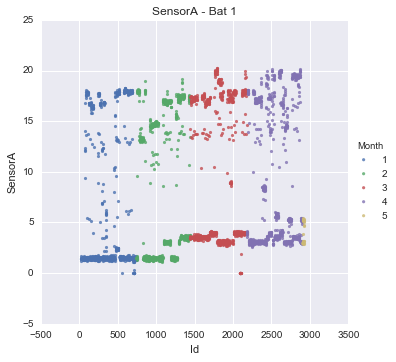

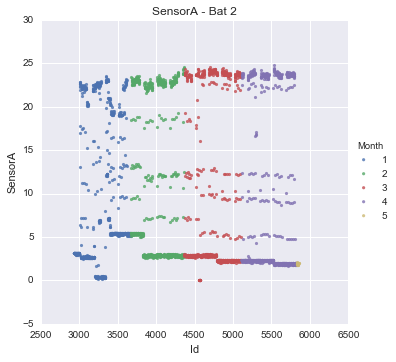

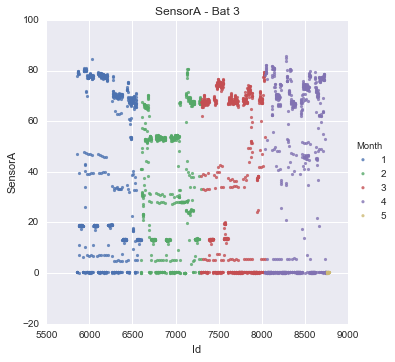

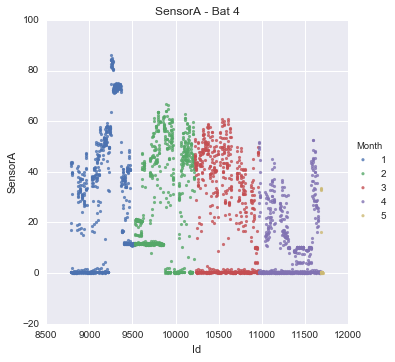

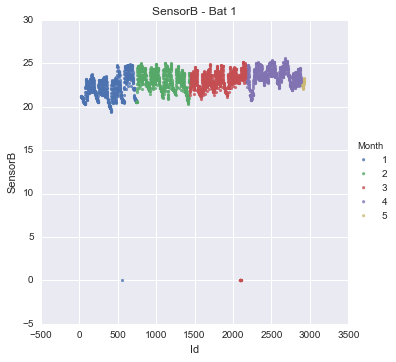

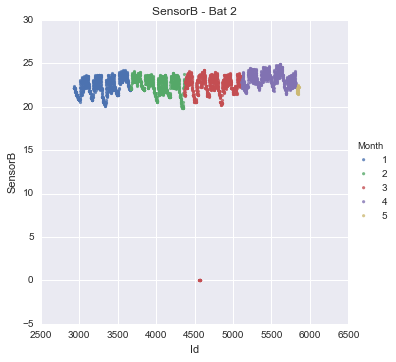

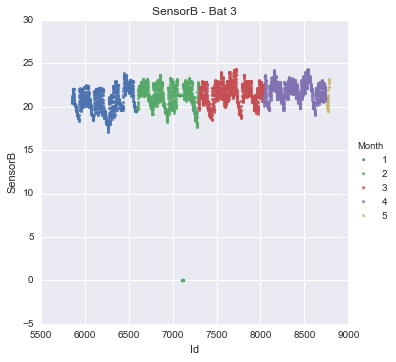

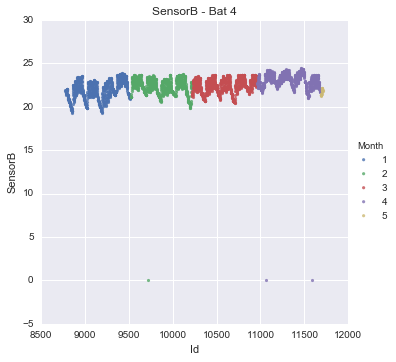

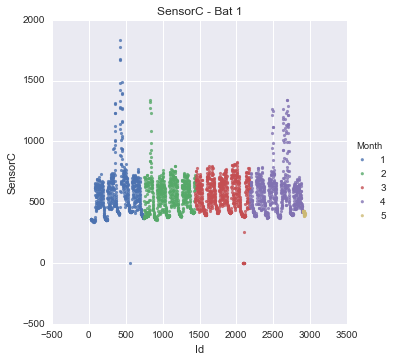

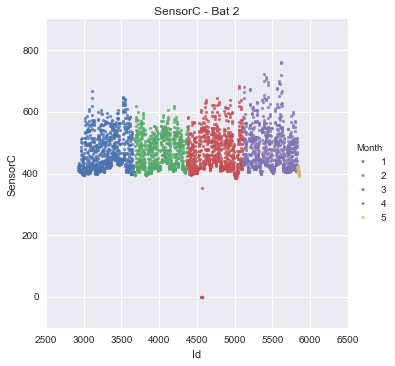

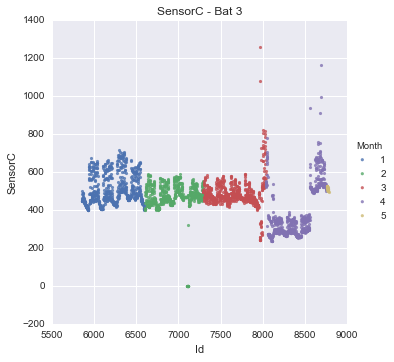

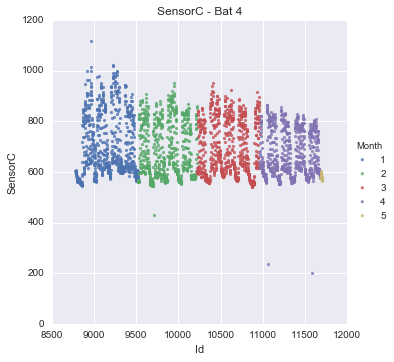

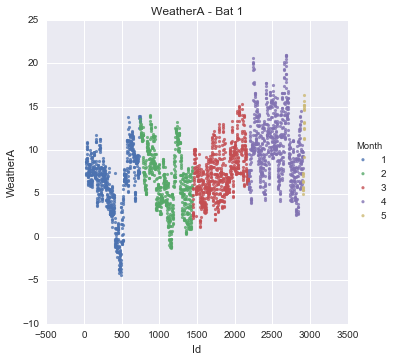

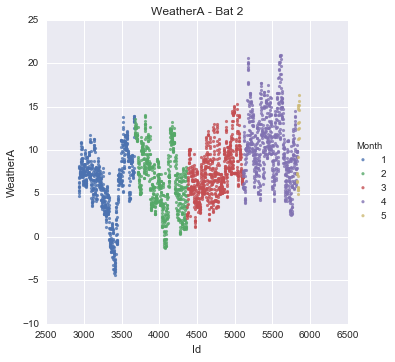

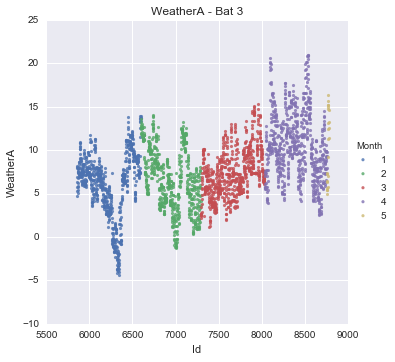

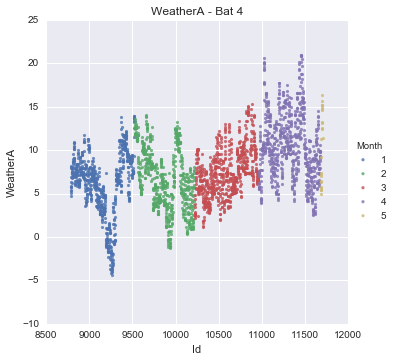

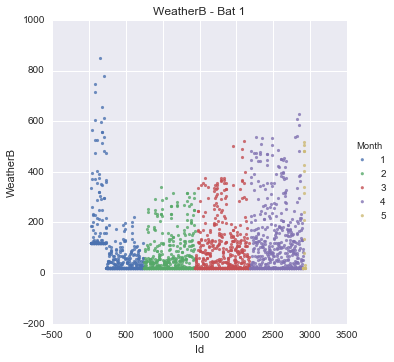

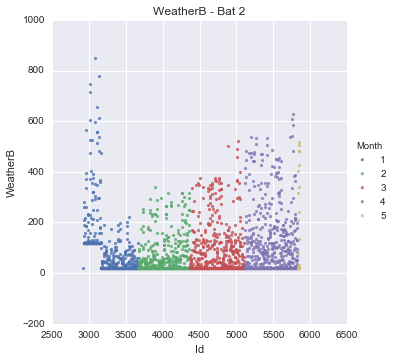

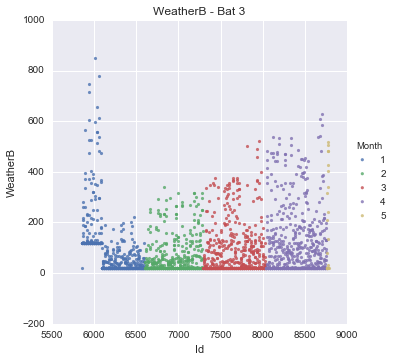

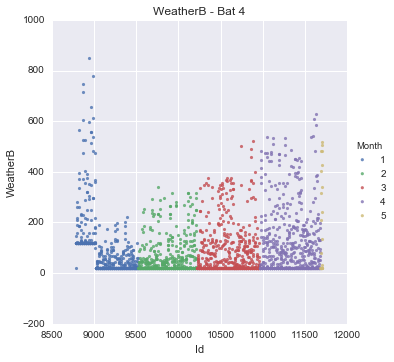

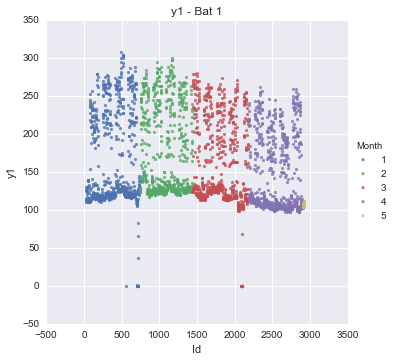

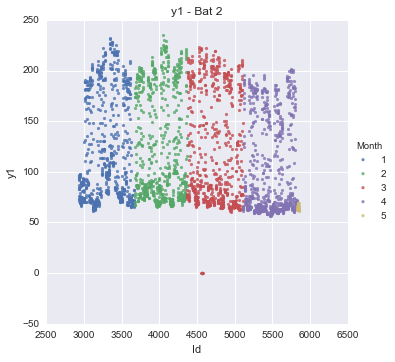

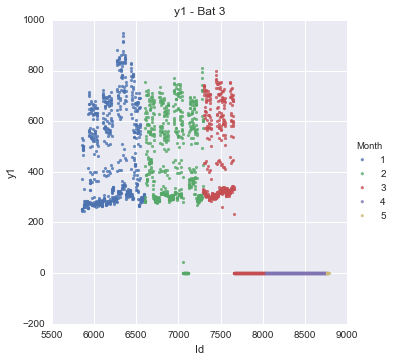

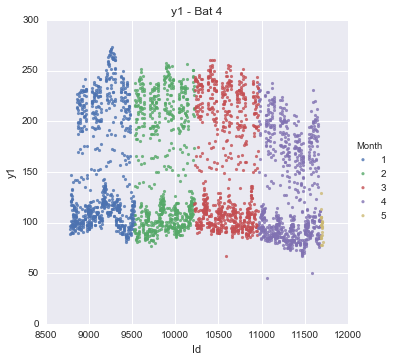

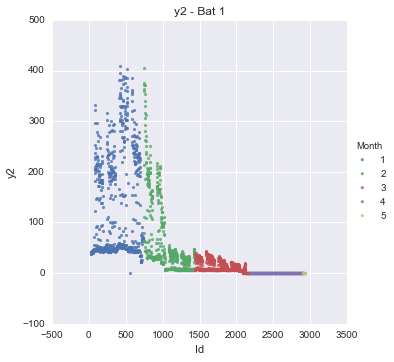

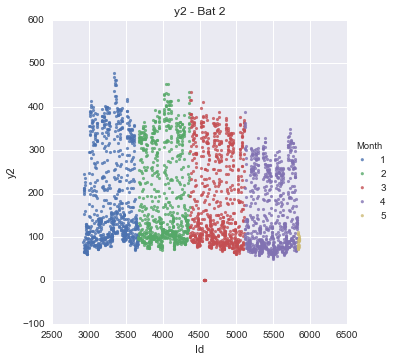

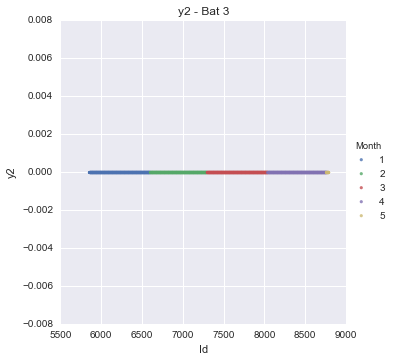

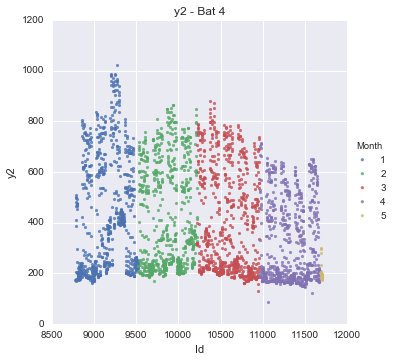

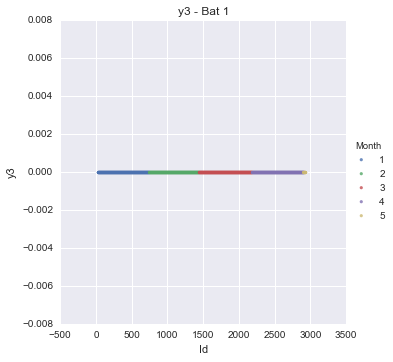

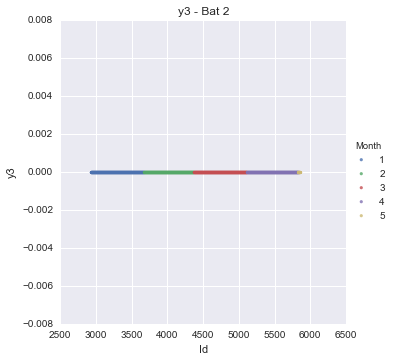

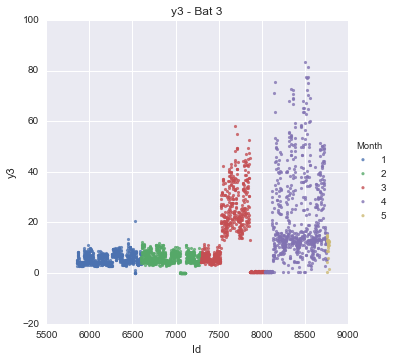

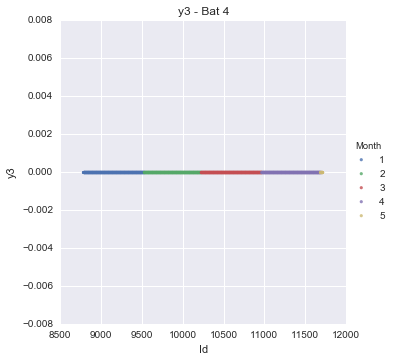

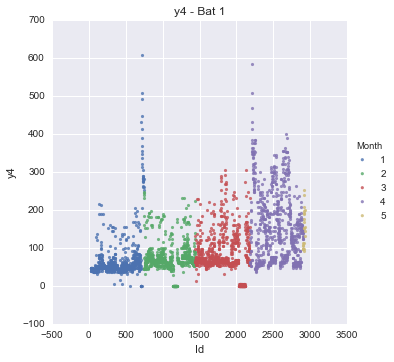

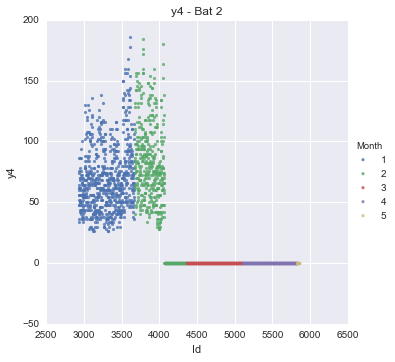

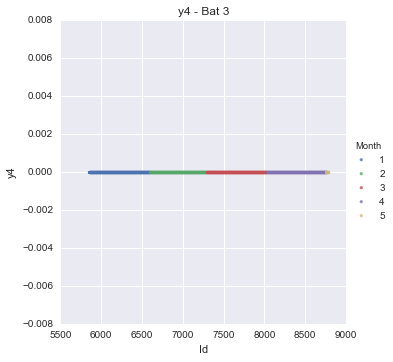

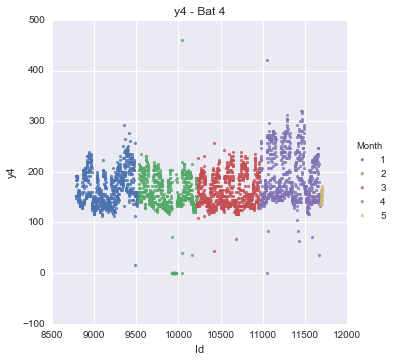

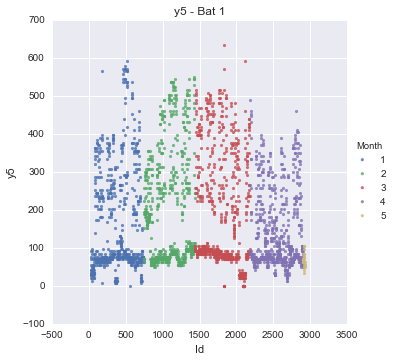

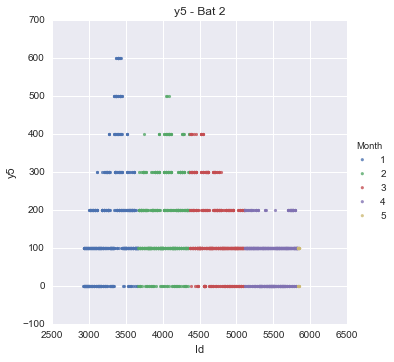

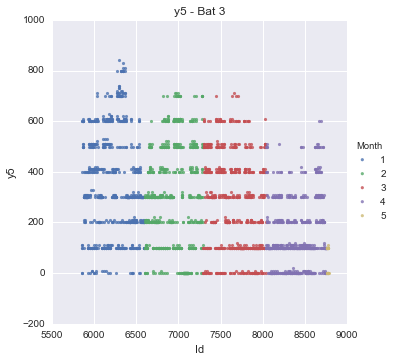

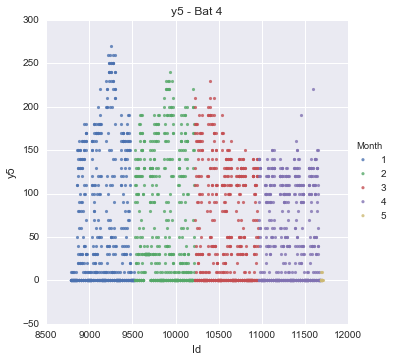

In [13]:
temp_train = pd.concat([train, y], axis = 1)
display(temp_train.head())

sns.lmplot(x = "Id", y = "SensorA", data = temp_train.loc[temp_train.Id_bat == 1], hue = "Month", fit_reg = False, scatter_kws={"s" : 10})
plt.title("SensorA - Bat 1")
plt.show()
sns.lmplot(x = "Id", y = "SensorA", data = temp_train.loc[temp_train.Id_bat == 2], hue = "Month", fit_reg = False, scatter_kws={"s" : 10})
plt.title("SensorA - Bat 2")
plt.show()
sns.lmplot(x = "Id", y = "SensorA", data = temp_train.loc[temp_train.Id_bat == 3], hue = "Month", fit_reg = False, scatter_kws={"s" : 10})
plt.title("SensorA - Bat 3")
plt.show()
sns.lmplot(x = "Id", y = "SensorA", data = temp_train.loc[temp_train.Id_bat == 4], hue = "Month", fit_reg = False, scatter_kws={"s" : 10})
plt.title("SensorA - Bat 4")
plt.show()

sns.lmplot(x = "Id", y = "SensorB", data = temp_train.loc[temp_train.Id_bat == 1], hue = "Month", fit_reg = False, scatter_kws={"s" : 10})
plt.title("SensorB - Bat 1")
plt.show()
sns.lmplot(x = "Id", y = "SensorB", data = temp_train.loc[temp_train.Id_bat == 2], hue = "Month", fit_reg = False, scatter_kws={"s" : 10})
plt.title("SensorB - Bat 2")
plt.show()
sns.lmplot(x = "Id", y = "SensorB", data = temp_train.loc[temp_train.Id_bat == 3], hue = "Month", fit_reg = False, scatter_kws={"s" : 10})
plt.title("SensorB - Bat 3")
plt.show()
sns.lmplot(x = "Id", y = "SensorB", data = temp_train.loc[temp_train.Id_bat == 4], hue = "Month", fit_reg = False, scatter_kws={"s" : 10})
plt.title("SensorB - Bat 4")
plt.show()

sns.lmplot(x = "Id", y = "SensorC", data = temp_train.loc[temp_train.Id_bat == 1], hue = "Month", fit_reg = False, scatter_kws={"s" : 10})
plt.title("SensorC - Bat 1")
plt.show()
sns.lmplot(x = "Id", y = "SensorC", data = temp_train.loc[temp_train.Id_bat == 2], hue = "Month", fit_reg = False, scatter_kws={"s" : 10})
plt.title("SensorC - Bat 2")
plt.show()
sns.lmplot(x = "Id", y = "SensorC", data = temp_train.loc[temp_train.Id_bat == 3], hue = "Month", fit_reg = False, scatter_kws={"s" : 10})
plt.title("SensorC - Bat 3")
plt.show()
sns.lmplot(x = "Id", y = "SensorC", data = temp_train.loc[temp_train.Id_bat == 4], hue = "Month", fit_reg = False, scatter_kws={"s" : 10})
plt.title("SensorC - Bat 4")
plt.show()

sns.lmplot(x = "Id", y = "WeatherA", data = temp_train.loc[temp_train.Id_bat == 1], hue = "Month", fit_reg = False, scatter_kws={"s" : 10})
plt.title("WeatherA - Bat 1")
plt.show()
sns.lmplot(x = "Id", y = "WeatherA", data = temp_train.loc[temp_train.Id_bat == 2], hue = "Month", fit_reg = False, scatter_kws={"s" : 10})
plt.title("WeatherA - Bat 2")
plt.show()
sns.lmplot(x = "Id", y = "WeatherA", data = temp_train.loc[temp_train.Id_bat == 3], hue = "Month", fit_reg = False, scatter_kws={"s" : 10})
plt.title("WeatherA - Bat 3")
plt.show()
sns.lmplot(x = "Id", y = "WeatherA", data = temp_train.loc[temp_train.Id_bat == 4], hue = "Month", fit_reg = False, scatter_kws={"s" : 10})
plt.title("WeatherA - Bat 4")
plt.show()

sns.lmplot(x = "Id", y = "WeatherB", data = temp_train.loc[temp_train.Id_bat == 1], hue = "Month", fit_reg = False, scatter_kws={"s" : 10})
plt.title("WeatherB - Bat 1")
plt.show()
sns.lmplot(x = "Id", y = "WeatherB", data = temp_train.loc[temp_train.Id_bat == 2], hue = "Month", fit_reg = False, scatter_kws={"s" : 10})
plt.title("WeatherB - Bat 2")
plt.show()
sns.lmplot(x = "Id", y = "WeatherB", data = temp_train.loc[temp_train.Id_bat == 3], hue = "Month", fit_reg = False, scatter_kws={"s" : 10})
plt.title("WeatherB - Bat 3")
plt.show()
sns.lmplot(x = "Id", y = "WeatherB", data = temp_train.loc[temp_train.Id_bat == 4], hue = "Month", fit_reg = False, scatter_kws={"s" : 10})
plt.title("WeatherB - Bat 4")
plt.show()

sns.lmplot(x = "Id", y = "y1", data = temp_train.loc[temp_train.Id_bat == 1], hue = "Month", fit_reg = False, scatter_kws={"s" : 10})
plt.title("y1 - Bat 1")
plt.show()
sns.lmplot(x = "Id", y = "y1", data = temp_train.loc[temp_train.Id_bat == 2], hue = "Month", fit_reg = False, scatter_kws={"s" : 10})
plt.title("y1 - Bat 2")
plt.show()
sns.lmplot(x = "Id", y = "y1", data = temp_train.loc[temp_train.Id_bat == 3], hue = "Month", fit_reg = False, scatter_kws={"s" : 10})
plt.title("y1 - Bat 3")
plt.show()
sns.lmplot(x = "Id", y = "y1", data = temp_train.loc[temp_train.Id_bat == 4], hue = "Month", fit_reg = False, scatter_kws={"s" : 10})
plt.title("y1 - Bat 4")
plt.show()

sns.lmplot(x = "Id", y = "y2", data = temp_train.loc[temp_train.Id_bat == 1], hue = "Month", fit_reg = False, scatter_kws={"s" : 10})
plt.title("y2 - Bat 1")
plt.show()
sns.lmplot(x = "Id", y = "y2", data = temp_train.loc[temp_train.Id_bat == 2], hue = "Month", fit_reg = False, scatter_kws={"s" : 10})
plt.title("y2 - Bat 2")
plt.show()
sns.lmplot(x = "Id", y = "y2", data = temp_train.loc[temp_train.Id_bat == 3], hue = "Month", fit_reg = False, scatter_kws={"s" : 10})
plt.title("y2 - Bat 3")
plt.show()
sns.lmplot(x = "Id", y = "y2", data = temp_train.loc[temp_train.Id_bat == 4], hue = "Month", fit_reg = False, scatter_kws={"s" : 10})
plt.title("y2 - Bat 4")
plt.show()

sns.lmplot(x = "Id", y = "y3", data = temp_train.loc[temp_train.Id_bat == 1], hue = "Month", fit_reg = False, scatter_kws={"s" : 10})
plt.title("y3 - Bat 1")
plt.show()
sns.lmplot(x = "Id", y = "y3", data = temp_train.loc[temp_train.Id_bat == 2], hue = "Month", fit_reg = False, scatter_kws={"s" : 10})
plt.title("y3 - Bat 2")
plt.show()
sns.lmplot(x = "Id", y = "y3", data = temp_train.loc[temp_train.Id_bat == 3], hue = "Month", fit_reg = False, scatter_kws={"s" : 10})
plt.title("y3 - Bat 3")
plt.show()
sns.lmplot(x = "Id", y = "y3", data = temp_train.loc[temp_train.Id_bat == 4], hue = "Month", fit_reg = False, scatter_kws={"s" : 10})
plt.title("y3 - Bat 4")
plt.show()

sns.lmplot(x = "Id", y = "y4", data = temp_train.loc[temp_train.Id_bat == 1], hue = "Month", fit_reg = False, scatter_kws={"s" : 10})
plt.title("y4 - Bat 1")
plt.show()
sns.lmplot(x = "Id", y = "y4", data = temp_train.loc[temp_train.Id_bat == 2], hue = "Month", fit_reg = False, scatter_kws={"s" : 10})
plt.title("y4 - Bat 2")
plt.show()
sns.lmplot(x = "Id", y = "y4", data = temp_train.loc[temp_train.Id_bat == 3], hue = "Month", fit_reg = False, scatter_kws={"s" : 10})
plt.title("y4 - Bat 3")
plt.show()
sns.lmplot(x = "Id", y = "y4", data = temp_train.loc[temp_train.Id_bat == 4], hue = "Month", fit_reg = False, scatter_kws={"s" : 10})
plt.title("y4 - Bat 4")
plt.show()

sns.lmplot(x = "Id", y = "y5", data = temp_train.loc[temp_train.Id_bat == 1], hue = "Month", fit_reg = False, scatter_kws={"s" : 10})
plt.title("y5 - Bat 1")
plt.show()
sns.lmplot(x = "Id", y = "y5", data = temp_train.loc[temp_train.Id_bat == 2], hue = "Month", fit_reg = False, scatter_kws={"s" : 10})
plt.title("y5 - Bat 2")
plt.show()
sns.lmplot(x = "Id", y = "y5", data = temp_train.loc[temp_train.Id_bat == 3], hue = "Month", fit_reg = False, scatter_kws={"s" : 10})
plt.title("y5 - Bat 3")
plt.show()
sns.lmplot(x = "Id", y = "y5", data = temp_train.loc[temp_train.Id_bat == 4], hue = "Month", fit_reg = False, scatter_kws={"s" : 10})
plt.title("y5 - Bat 4")
plt.show()
